In [ ]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
# 驗證函數
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

In [2]:
# 驗證一
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [3]:
!pip install pandas_datareader==0.10.0

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
import pandas_datareader.data as web
# 第一個數據
predict_days = 6 # 用過去6天預測下一天
df = web.DataReader('2330.tw', 'yahoo', '1999-01-01', '2021-10-27')
data = df.reset_index()
data['TickerId']   = '2330'
data['TickerName'] = '台積電'
data[-3:]

,Date,High,Low,Open,Close,Volume,Adj Close,TickerId,TickerName
5450,2021-10-25,597.0,590.0,597.0,593.0,16785568.0,593.0,2330,台積電
5451,2021-10-26,600.0,593.0,595.0,599.0,19998808.0,599.0,2330,台積電
5452,2021-10-27,598.0,594.0,598.0,599.0,15090461.0,599.0,2330,台積電


In [5]:
# 使用台積電股價 驗證  ????
# define input sequence
raw_seq = data.Close #[10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 6
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

In [6]:
X[-4:], y[-4:]

(array([[573., 600., 590., 600., 598., 596.],
        [600., 590., 600., 598., 596., 600.],
        [590., 600., 598., 596., 600., 593.],
        [600., 598., 596., 600., 593., 599.]]),
 array([600., 593., 599., 599.]))

In [7]:
# 使用 LSTM 看前看後記憶
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
n_steps = 6
n_features = 1
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [8]:
X = X.reshape((X.shape[0], X.shape[1], n_features)) # 多出一個維度

In [11]:
X.shape

(5447, 6, 1)

In [12]:
# fit model
history = model.fit(X, y, epochs=20, verbose=2)

Epoch 1/20
171/171 - 5s - loss: 2918.8833
Epoch 2/20
171/171 - 3s - loss: 26.0039
Epoch 3/20
171/171 - 3s - loss: 25.5641
Epoch 4/20
171/171 - 3s - loss: 24.5912
Epoch 5/20
171/171 - 3s - loss: 25.0559
Epoch 6/20
171/171 - 3s - loss: 23.8553
Epoch 7/20
171/171 - 3s - loss: 22.6171
Epoch 8/20
171/171 - 3s - loss: 23.7154
Epoch 9/20
171/171 - 3s - loss: 22.6344
Epoch 10/20
171/171 - 3s - loss: 21.0707
Epoch 11/20
171/171 - 3s - loss: 21.1758
Epoch 12/20
171/171 - 3s - loss: 23.4309
Epoch 13/20
171/171 - 3s - loss: 21.9843
Epoch 14/20
171/171 - 3s - loss: 21.8503
Epoch 15/20
171/171 - 3s - loss: 18.5742
Epoch 16/20
171/171 - 3s - loss: 27.5547
Epoch 17/20
171/171 - 3s - loss: 24.9923
Epoch 18/20
171/171 - 3s - loss: 27.3719
Epoch 19/20
171/171 - 3s - loss: 25.3200
Epoch 20/20
171/171 - 3s - loss: 23.2224


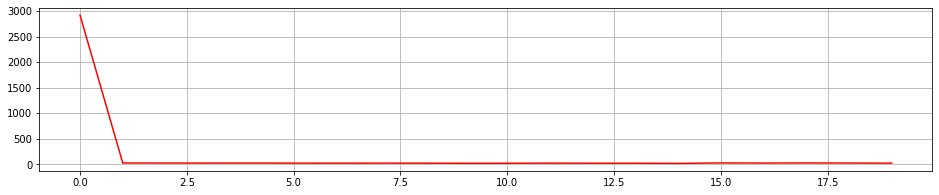

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,3))
plt.grid()
plt.plot( history.history.get('loss') , color='red')
plt.show()

In [16]:
# 使用 Deep Learning 進行預測
# 重要數據
pre_Close = model.predict(X).ravel()
Close = y

sum((pre_Close - Close)**2) / len(Close)

28.696631399314896

c:\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


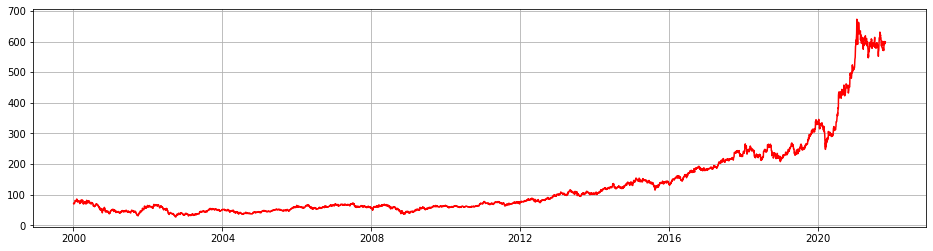

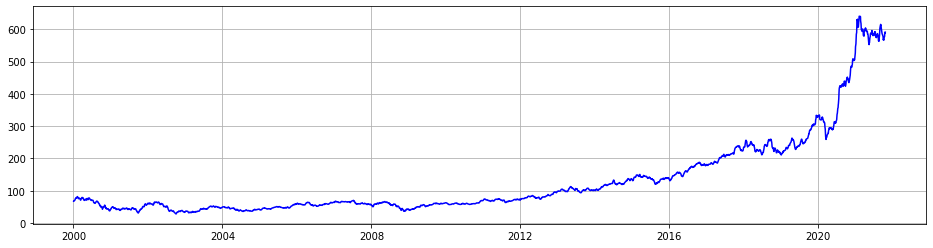

In [18]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

data_plot = data[:len(pre_Close)]

plt.figure(figsize=(16,4))
plt.grid()
plt.plot(pd.to_datetime(data_plot.Date), Close, color='red')
plt.show()

plt.figure(figsize=(16,4))
plt.grid()
plt.plot(pd.to_datetime(data_plot.Date), pre_Close, color='blue')
plt.show()

In [19]:
X.shape
model.predict(X[-1].reshape(1, X[-1].shape[0], X[-1].shape[1]))

array([[590.5063]], dtype=float32)

In [20]:
X[-1]

array([[600.],
       [598.],
       [596.],
       [600.],
       [593.],
       [599.]])

In [21]:
# 針對最近數據預測 Deep Learning
# 預測下個十天TSMC 股價
import numpy as np
from datetime import timedelta

# 下一天
next_data = X[-1]
next_day = model.predict(X[-1].reshape(1, X[-1].shape[0], X[-1].shape[1]))
print(next_day[0], data.Date[-1:].dt.strftime("%Y-%m-%d").values[0])

#next_data, next_day[0]

#np.vstack( (next_data , next_day[0]) )[-5:, :]


# 剩下的天數 再預測
for i in range(1, 10, 1):
    next_data = np.vstack( (next_data , next_day[0]) )[-1*predict_days:, :]
    next_day = model.predict(next_data.reshape(1, next_data.shape[0], next_data.shape[1]))
    print(next_day[0],  (data.Date[-1:] + timedelta(days=i)).dt.strftime("%Y-%m-%d").values[0]  )


[590.5063] 2021-10-27
[588.11835] 2021-10-28
[586.57385] 2021-10-29
[585.4118] 2021-10-30
[583.0335] 2021-10-31
[581.5522] 2021-11-01
[578.47296] 2021-11-02
[576.3698] 2021-11-03
[574.489] 2021-11-04
[572.57916] 2021-11-05
